In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [2]:
image_size = (48, 48)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/train",
    validation_split=0.2,
    subset="training",
#     label_mode = 'categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
            
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/train",
    validation_split=0.2,
    subset="validation",
#     label_mode = 'categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    seed=1337,
#     label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


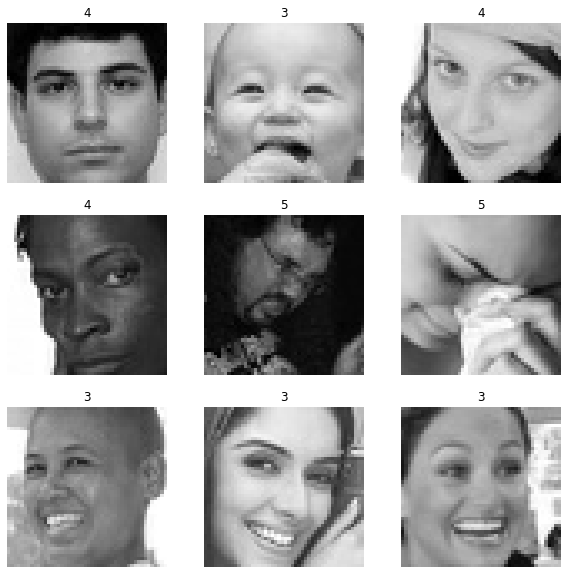

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [5]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [6]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import regularizers

def build_model(num_classes=7):
    inputs = layers.Input(shape=(48, 48, 3))
    x = img_augmentation(inputs)
#     model = DenseNet201(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
#     model.trainable = False
    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
#     x = layers.Conv2D(3layers.malization()(x)
    
#     x = layers.Conv2D(64,  3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.MaxPooling2D(2, 2)(x)
#     x = layers.Conv2D(128,  3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D(2, 2)(x)
#     x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
# #     x = layers.Conv2D(64, 3, activation='relu')(x)
# #     x = layers.BatchNormalization()(x)

#     # Rebuild top
#     x = layers.MaxPooling2D(2, 2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Flatten()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(0.25, name="top_dropout")(x)
#     x = layers.Dense(512, activation="relu", name="dense")(x)
    x = layers.Dropout(0.4, name="top2_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001, decay=1e-6)
    model.compile( optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    return model

In [7]:
model = build_model()
epochs = 10

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath="./output/", save_best_only=True, verbose=1, mode='min', moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)
callbacks = [checkpoint, reduce_lr]
hist = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=callbacks, verbose=2)

Epoch 1/10


KeyboardInterrupt: 